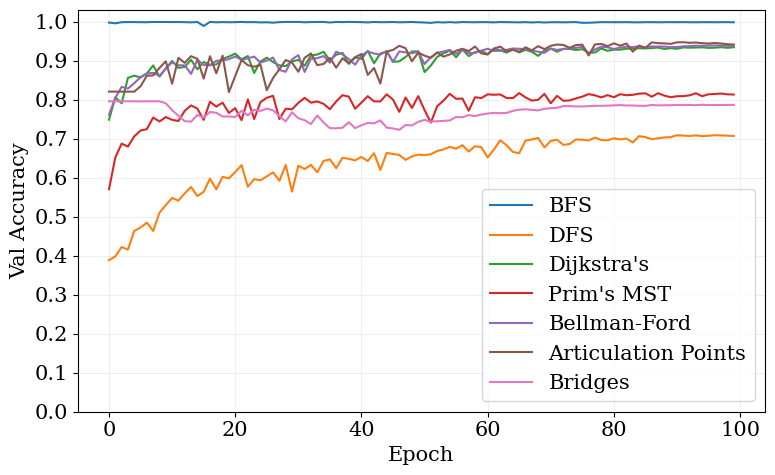

In [21]:
import matplotlib
import matplotlib.pyplot as plt
import torch

algorithms=['bfs', 'dfs', 'dijkstra', 'mst_prim', 'bellman_ford', 'articulation_points', 'bridges']
algorithms_plot = ['BFS', 'DFS', "Dijkstra's", 'Prim\'s MST', 'Bellman-Ford', 'Articulation Points', 'Bridges']
lr=0.001
eta=0.001
weight_decay=0.1
lambda_hint = 1.0
batch_size=32
epochs=100
seed=0
model='GINE'

matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams['font.family'] = 'serif'

fig, ax_acc = plt.subplots(1, 1, figsize=(8,5))
config_str = f'distributed_{model}_l1_schedule_lr={lr}_eta={eta}_weight_decay={weight_decay}_batch_size={batch_size}_seed={seed}'
checkpoint_path = f'checkpoints/{config_str}/'
val_accs = torch.load(f'{checkpoint_path}val_accs.pt')

for task, task_plot in zip(algorithms, algorithms_plot):
    ax_acc.plot(val_accs[task][:epochs], label=task_plot)
ax_acc.set_yticks(torch.arange(0, 1.1, 0.1))
ax_acc.grid(alpha=0.2)
ax_acc.set_xlabel('Epoch')
ax_acc.set_ylabel('Val Accuracy')
ax_acc.legend()
fig.tight_layout()
plt.savefig(f'figures/{config_str}_val_accs.png', dpi=300)
plt.show()


Mean Final Test Accuracy: 0.758001800094332


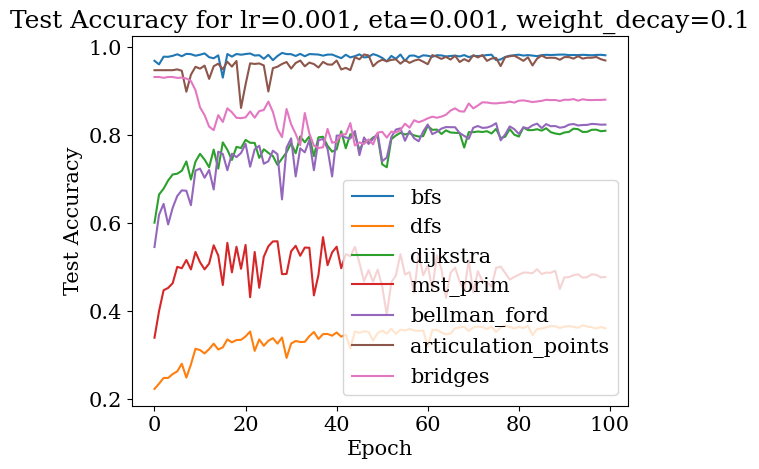

In [22]:
test_accs = torch.load(f'{checkpoint_path}test_accs.pt')
final_test_accs = {task: test_accs[task][epochs-1] for task in algorithms}
mean_final_test_acc = sum(final_test_accs.values()) / len(algorithms)
print(f'Mean Final Test Accuracy: {mean_final_test_acc}')

for task in algorithms:
    plt.plot(test_accs[task][:epochs], label=task)
plt.title(f'Test Accuracy for lr={lr}, eta={eta}, weight_decay={weight_decay}')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()

In [23]:
best_epoch = torch.load(f'{checkpoint_path}training_state_in_progress.pt')['best_epoch']
for task in algorithms:
    print(f'{task} best val acc: {val_accs[task][best_epoch-1]:.4f}. Best test acc: {test_accs[task][best_epoch-1]:.4f}')


bfs best val acc: 0.9990. Best test acc: 0.9825
dfs best val acc: 0.7073. Best test acc: 0.3642
dijkstra best val acc: 0.9337. Best test acc: 0.8150
mst_prim best val acc: 0.8115. Best test acc: 0.4818
bellman_ford best val acc: 0.9375. Best test acc: 0.8255
articulation_points best val acc: 0.9463. Best test acc: 0.9742
bridges best val acc: 0.7868. Best test acc: 0.8822


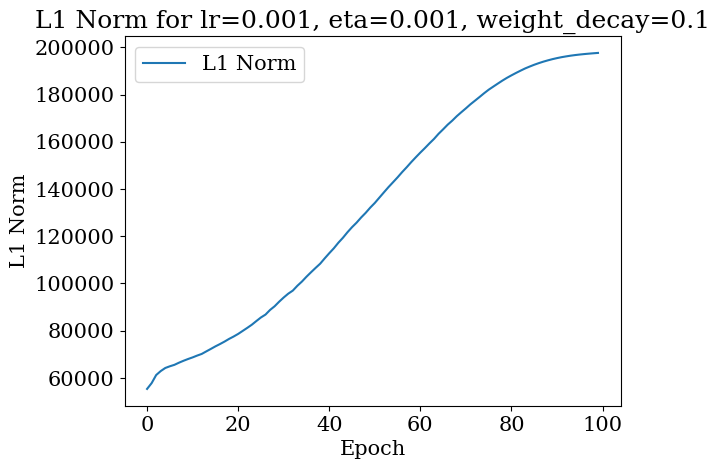

In [24]:
l1_regs = torch.load(f'{checkpoint_path}l1_norms.pt')
plt.plot(l1_regs[:epochs], label='L1 Norm')
plt.title(f'L1 Norm for lr={lr}, eta={eta}, weight_decay={weight_decay}')
plt.xlabel('Epoch')
plt.ylabel('L1 Norm')
plt.legend()

processor.convs.0.nn.lins.0.weight: L0 = 1404, sparsity = 97.14%
processor.convs.0.nn.lins.1.weight: L0 = 1368, sparsity = 91.65%
processor.convs.0.lin.weight: L0 = 66, sparsity = 82.81%
processor.convs.1.nn.lins.0.weight: L0 = 1455, sparsity = 91.12%
processor.convs.1.nn.lins.1.weight: L0 = 941, sparsity = 94.26%
processor.convs.1.lin.weight: L0 = 55, sparsity = 57.03%


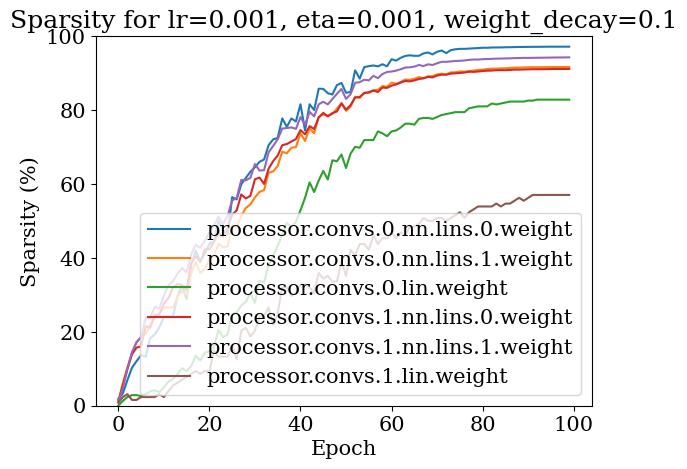

In [30]:
eps = 1e-3
sparsities = {}
l0s = {}
for i in range(len(l1_regs)):
    checkpoint = torch.load(f'{checkpoint_path}model_in_progress_{i}.pt', map_location='cpu')
    for name, param in checkpoint.items():
        if 'processor' in name:
            num_params = param.numel()
            l0 = torch.sum(torch.abs(param) > eps).item()
            sparsities[name] = sparsities.get(name, []) + [100.0 * (1 - l0 / num_params)]
            l0s[name] = l0
for name, sparsity in sparsities.items():
    if 'weight' in name:
        plt.plot(sparsity, label=name)
        print(f'{name}: L0 = {l0s[name]}, sparsity = {sparsity[-1]:.2f}%')
    # elif 'bias' in name:
    #     plt.plot(sparsity, label=name, linestyle='--')
plt.ylim(0, 100)
plt.title(f'Sparsity for lr={lr}, eta={eta}, weight_decay={weight_decay}')
plt.xlabel('Epoch')
plt.ylabel('Sparsity (%)')
plt.legend()

In [ ]:
import sys
sys.path.append('../')
sys.path.append('./SALSA-CLRS/')

import torch
from model.GINE import GINE
from EncodeProcessDecode import EncodeProcessDecode

from loguru import logger
from baselines.core.models.encoder import Encoder
from baselines.core.models.decoder import Decoder
from salsaclrs import specs

device = torch.device('cuda')

lr = 0.001
eta = 0.001
weight_decay = 0.1

algorithms = ['bfs', 'dfs', 'dijkstra', 'mst_prim', 'bellman_ford', 'articulation_points', 'bridges']
output_types = {
    'bfs' : 'pointer',
    'dfs' : 'pointer',
    'dijkstra' : 'pointer',
    'mst_prim' : 'pointer',
    'bellman_ford' : 'pointer',
    'articulation_points' : 'mask',
    'bridges' : 'pointer',
}
logger.disable('baselines.core.models.encoder')
logger.disable('baselines.core.models.decoder')

hidden_dim = 128
encoders = torch.nn.ModuleDict({
    task : Encoder(specs=specs.SPECS[task]) for task in algorithms
})

decoders = torch.nn.ModuleDict({
    task : Decoder(specs=specs.SPECS[task], 
                   hidden_dim = hidden_dim * 2,
                   no_hint=False) for task in algorithms
})

for encoder in encoders.values():
    encoder.to(device)
for decoder in decoders.values():
    decoder.to(device)
processor = GINE(3*128, 128, 2, 128, edge_dim=1, aggr='max')
processor.to(device)
model = EncodeProcessDecode(encoders, decoders, processor, device=device)

model_checkpoint = f'distributed_GINE_l1_schedule_lr={lr}_eta={eta}_weight_decay={weight_decay}_batch_size=32_seed=0/model_best.pt'
model_state = torch.load(f'checkpoints/{model_checkpoint}', map_location=device)
model.load_state_dict(model_state)
model.eval()
model.to(device)